In [2]:
import torch
import torch.nn.functional as F 
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
words = open('names.txt', 'r').read().splitlines()
len(words)

32033

In [15]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [16]:
# build the dataset

block_size = 3     # context length (chars we take to predict the next one)
X, Y = [], []
for w in words[:1]:
  print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    # like a queue or sliding window (remove the prev. and add next one)
    context = context[1:] + [ix]    # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)
X

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .


tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1]])

In [17]:
X.shape, Y.shape

(torch.Size([5, 3]), torch.Size([5]))

 27 chars with 2-D embedding

In [18]:
# fitting 27 chars in 2 Dimensions
C = torch.randn((27, 2))

C[5] is equivalent of one_hot tensor(5) then @ with C

for each index in X -> C[X] fetches corresponding row from C

Shape of C[X] -> num_sampls, block_size, 2

In [19]:
# can access multiple rows from C
print(C[[1,2,5,6,5]])
# passing in X
print(C[X].shape)

tensor([[-0.4388,  1.2425],
        [ 0.4856, -0.7846],
        [-0.9171, -0.1389],
        [-0.1609, -0.1315],
        [-0.9171, -0.1389]])
torch.Size([5, 3, 2])


In [20]:
print(X[4, 2])
# gets emb for [4, 2] in X, which is 1, so they are equal
print(C[X][4, 2])
# gets emb for char index 1
print(C[1])

tensor(1)
tensor([-0.4388,  1.2425])
tensor([-0.4388,  1.2425])


In [35]:
# embedding
emb = C[X]
emb.shape

torch.Size([5, 3, 2])

In [22]:
# IP -> 3*2, 100=no. of neurons
w1 = torch.randn((6, 100))
b1 = torch.randn(100)

can't multiply emb and w1 since different Dims., so we use concatenate

In [23]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1)

tensor([[-0.2514,  1.2032, -0.2514,  1.2032, -0.2514,  1.2032],
        [-0.2514,  1.2032, -0.2514,  1.2032, -0.9171, -0.1389],
        [-0.2514,  1.2032, -0.9171, -0.1389, -0.0191,  0.0619],
        [-0.9171, -0.1389, -0.0191,  0.0619, -0.0191,  0.0619],
        [-0.0191,  0.0619, -0.0191,  0.0619, -0.4388,  1.2425]])

instead of writing each index

In [24]:
torch.cat(torch.unbind(emb,1), 1)

tensor([[-0.2514,  1.2032, -0.2514,  1.2032, -0.2514,  1.2032],
        [-0.2514,  1.2032, -0.2514,  1.2032, -0.9171, -0.1389],
        [-0.2514,  1.2032, -0.9171, -0.1389, -0.0191,  0.0619],
        [-0.9171, -0.1389, -0.0191,  0.0619, -0.0191,  0.0619],
        [-0.0191,  0.0619, -0.0191,  0.0619, -0.4388,  1.2425]])

In [30]:
a = torch.arange(18)
a.view(3, 3, 2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [31]:
emb.view(5, 6)

tensor([[-0.2514,  1.2032, -0.2514,  1.2032, -0.2514,  1.2032],
        [-0.2514,  1.2032, -0.2514,  1.2032, -0.9171, -0.1389],
        [-0.2514,  1.2032, -0.9171, -0.1389, -0.0191,  0.0619],
        [-0.9171, -0.1389, -0.0191,  0.0619, -0.0191,  0.0619],
        [-0.0191,  0.0619, -0.0191,  0.0619, -0.4388,  1.2425]])

In [39]:
# h = emb.view(emb.shape[0], 6) @ w1 + b1
# automatically assigns it to amtch with 6 and maintain shape
h = torch.tanh(emb.view(-1, 6) @ w1 + b1)
h.shape

torch.Size([5, 100])

In [40]:
# IP -> 100 and OP -> 27 (chars)
w2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [41]:
logits = h @ w2 + b2
logits.shape

torch.Size([5, 27])

In [43]:
counts = logits.exp()

In [47]:
probs = counts / counts.sum(1, keepdim=True)
print(probs.shape)
print(probs[0].sum())

torch.Size([5, 27])
tensor(1.0000)


In [50]:
loss = -probs[torch.arange(5), Y].log().mean()
loss

tensor(15.8786)

----------------- In one Go -----------------

In [62]:
# build the dataset

block_size = 3     # context length
X, Y = [], []
for w in words:
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    context = context[1:] + [ix]    # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [63]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [106]:
g = torch.Generator().manual_seed(2347483647)
C = torch.randn((27, 2), generator=g)
w1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
w2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
params = [C, w1, b1, w2, b2]
for p in params:
  p.requires_grad = True

In [85]:
sum(p.nelement() for p in params)  # total params

3481

for each sample i probs[i, Y[i]] gives the probability assigned by your model to the true next character.

In [72]:
for _ in range(10):
  emb = C[X]
  h = torch.tanh(emb.view(-1, 6) @ w1 + b1)
  logits = h @ w2 + b2
  # counts = logits.exp()
  # probs = counts / counts.sum(1, keepdim=True)
  # loss = -probs[torch.arange(5), Y].log().mean()
  loss = F.cross_entropy(logits, Y)
  print(loss.item())

  # backward pass
  for p in params:
    p.grad = None
  loss.backward()

  # update
  for p in params:
    p.data += -0.1 * p.grad

3.808462619781494
3.7942488193511963
3.7803452014923096
3.7667341232299805
3.753398895263672
3.7403247356414795
3.7274975776672363
3.714904308319092
3.7025341987609863
3.6903762817382812


In [ ]:
# batching as many examples
# 32 ints between 0 - range
torch.randint(0, X.shape[0], (32,))

tensor([4, 4, 0, 0, 3, 2, 3, 3, 0, 4, 2, 1, 2, 2, 1, 3, 1, 3, 2, 4, 3, 2, 3, 4,
        4, 2, 2, 3, 0, 2, 3, 2])

In [103]:
# start with a lr = 0.001 and move till 1
lre = torch.linspace(-3, 0, steps=1000)
lrs = 10**lre

In [107]:
lri = []
lossi = []
for i in range(1000):
  # mini batch construct
  ix = torch.randint(0, X.shape[0], (32,))

  emb = C[X[ix]]      # now -> (32, 3, 2)
  h = torch.tanh(emb.view(-1, 6) @ w1 + b1)
  logits = h @ w2 + b2
  loss = F.cross_entropy(logits, Y[ix])
  # print(loss.item())

  # backward pass
  for p in params:
    p.grad = None
  loss.backward()

  # update
  # also using diff. lr's
  lr = lrs[i]
  for p in params:
    p.data += -lr * p.grad

  lri.append(lre[i])
  lossi.append(loss.item())

print(loss.item())

7.391108989715576


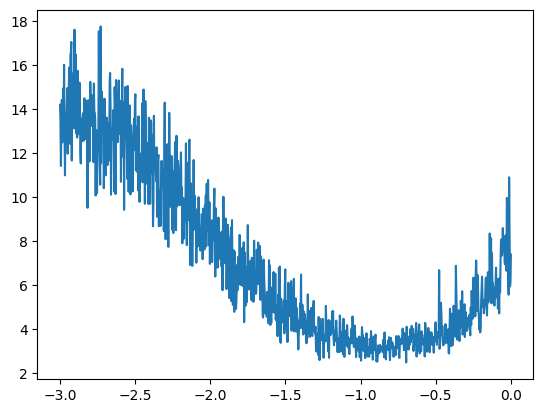

In [ ]:
plt.plot(lri, lossi)
# we can see lr = 0.1 is good enough